### **Importing the neccassary Libraries**

In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler , OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.linear_model import LinearRegression 
from xgboost import XGBRegressor
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore')
import joblib

In [11]:
df = pd.read_csv("housing_price_dataset.csv")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


In [13]:
df.head(5)

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


### **Feature Engineering**

In [14]:

df['Age'] = 2025 - df['YearBuilt']
df['SqFt_Per_Bedroom'] = df['SquareFeet'] / df['Bedrooms'].replace(0, 1)
df['Bed_Bath_Ratio'] = df['Bedrooms'] / df['Bathrooms'].replace(0, 1)
df['Log_SquareFeet'] = np.log1p(df['SquareFeet'])
df['Total_Rooms'] = df['Bedrooms'] + df['Bathrooms']


# Adjusted bins: Ensure monotonicity by filtering or capping
max_sqft = df['SquareFeet'].max()
base_bins = [0, 1000, 2000, 3000, 4000]
bins = sorted(list(set(base_bins + [max_sqft])))  # Remove duplicates and sort
labels = ['Small', 'Medium', 'Large', 'XL', 'Mansion'][:len(bins)-1]  # Match labels to bins
df['Home_Size_Category'] = pd.cut(df['SquareFeet'], bins=bins, labels=labels, include_lowest=True)


df['Bed_Bath_Interaction'] = df['Bedrooms'] * df['Bathrooms']

# Display sample
print(df[['Price', 'SquareFeet', 'Age', 'Home_Size_Category']].head())

           Price  SquareFeet  Age Home_Size_Category
0  215355.283618        2126   56              Large
1  195014.221626        2459   45              Large
2  306891.012076        1860   55             Medium
3  206786.787153        2294   29              Large
4  272436.239065        2130   24              Large


In [15]:
df

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price,Age,SqFt_Per_Bedroom,Bed_Bath_Ratio,Log_SquareFeet,Total_Rooms,Home_Size_Category,Bed_Bath_Interaction
0,2126,4,1,Rural,1969,215355.283618,56,531.500000,4.000000,7.662468,5,Large,4
1,2459,3,2,Rural,1980,195014.221626,45,819.666667,1.500000,7.807917,5,Large,6
2,1860,2,1,Suburb,1970,306891.012076,55,930.000000,2.000000,7.528869,3,Medium,2
3,2294,2,1,Urban,1996,206786.787153,29,1147.000000,2.000000,7.738488,3,Large,2
4,2130,5,2,Suburb,2001,272436.239065,24,426.000000,2.500000,7.664347,7,Large,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1282,5,3,Rural,1975,100080.865895,50,256.400000,1.666667,7.156956,8,Medium,15
49996,2854,2,2,Suburb,1988,374507.656727,37,1427.000000,1.000000,7.956827,4,Large,4
49997,2979,5,3,Suburb,1962,384110.555590,63,595.800000,1.666667,7.999679,8,Large,15
49998,2596,5,2,Rural,1984,380512.685957,41,519.200000,2.500000,7.862112,7,Large,10


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   SquareFeet            50000 non-null  int64   
 1   Bedrooms              50000 non-null  int64   
 2   Bathrooms             50000 non-null  int64   
 3   Neighborhood          50000 non-null  object  
 4   YearBuilt             50000 non-null  int64   
 5   Price                 50000 non-null  float64 
 6   Age                   50000 non-null  int64   
 7   SqFt_Per_Bedroom      50000 non-null  float64 
 8   Bed_Bath_Ratio        50000 non-null  float64 
 9   Log_SquareFeet        50000 non-null  float64 
 10  Total_Rooms           50000 non-null  int64   
 11  Home_Size_Category    50000 non-null  category
 12  Bed_Bath_Interaction  50000 non-null  int64   
dtypes: category(1), float64(4), int64(7), object(1)
memory usage: 4.6+ MB


### **Seperating Numerical Columns and Categorical Columns**

In [17]:
numerical_cols = [
    'SquareFeet',
    'Bedrooms',
    'Bathrooms',
    'YearBuilt',
    'Age',
    'SqFt_Per_Bedroom',
    'Bed_Bath_Ratio',
    'Log_SquareFeet',
    'Total_Rooms',
    'Bed_Bath_Interaction'
]
categorical_cols = [
    'Neighborhood',
    'Home_Size_Category',
]

### **Seperating Input Columns and Target Column**

In [18]:
input_cols = ['SquareFeet',
    'Bedrooms',
    'Bathrooms',
    'YearBuilt',
    'Age',
    'SqFt_Per_Bedroom',
    'Bed_Bath_Ratio',
    'Log_SquareFeet',
    'Total_Rooms',
    'Bed_Bath_Interaction',
    'Neighborhood',
    'Home_Size_Category']
target_col = "Price"

In [19]:
x_df = df[input_cols]
y_df = df[target_col]

### **Scaling Numerical Columns**

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler.fit(x_df[numerical_cols])

MinMaxScaler()

In [22]:
x_df[numerical_cols] = scaler.transform(x_df[numerical_cols])

In [23]:
x_df[numerical_cols].describe().loc[['min',"max"]]

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Age,SqFt_Per_Bedroom,Bed_Bath_Ratio,Log_SquareFeet,Total_Rooms,Bed_Bath_Interaction
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### **Encoding Categorical Columns**

In [24]:
encoder = OneHotEncoder(sparse_output=False,handle_unknown="ignore")
encoder.fit(pd.DataFrame(x_df[categorical_cols]))

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [25]:
encoded_cols = list(encoder.get_feature_names_out())

In [26]:
encoded_cols

['Neighborhood_Rural',
 'Neighborhood_Suburb',
 'Neighborhood_Urban',
 'Home_Size_Category_Large',
 'Home_Size_Category_Medium',
 'Home_Size_Category_Small']

In [27]:
x_df[encoded_cols] = encoder.transform(pd.DataFrame(x_df[categorical_cols]))

In [28]:
x_df = x_df[numerical_cols + encoded_cols]

In [29]:
x_df

,SquareFeet,Bedrooms,Bathrooms,YearBuilt,Age,SqFt_Per_Bedroom,Bed_Bath_Ratio,Log_SquareFeet,Total_Rooms,Bed_Bath_Interaction,Neighborhood_Rural,Neighborhood_Suburb,Neighborhood_Urban,Home_Size_Category_Large,Home_Size_Category_Medium,Home_Size_Category_Small
0,0.563282,0.666667,0.0,0.267606,0.732394,0.255098,0.769231,0.686684,0.4,0.153846,1.0,0.0,0.0,1.0,0.0,0.0
1,0.729865,0.333333,0.5,0.422535,0.577465,0.476850,0.192308,0.819198,0.4,0.307692,1.0,0.0,0.0,1.0,0.0,0.0
2,0.430215,0.000000,0.0,0.281690,0.718310,0.561755,0.307692,0.564967,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0
3,0.647324,0.000000,0.0,0.647887,0.352113,0.728742,0.307692,0.755944,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0
4,0.565283,1.000000,0.5,0.718310,0.281690,0.173913,0.423077,0.688396,0.8,0.615385,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.141071,1.000000,1.0,0.352113,0.647887,0.043401,0.230769,0.226129,1.0,1.000000,1.0,0.0,0.0,0.0,1.0,0.0
49996,0.927464,0.000000,0.5,0.535211,0.464789,0.944209,0.076923,0.954865,0.2,0.153846,0.0,1.0,0.0,1.0,0.0,0.0
49997,0.989995,1.000000,1.0,0.169014,0.830986,0.304579,0.230769,0.993906,1.0,1.000000,0.0,1.0,0.0,1.0,0.0,0.0
49998,0.798399,1.000000,0.5,0.478873,0.521127,0.245633,0.423077,0.868574,0.8,0.615385,1.0,0.0,0.0,1.0,0.0,0.0


In [30]:
y_df

0        215355.283618
1        195014.221626
2        306891.012076
3        206786.787153
4        272436.239065
             ...      
49995    100080.865895
49996    374507.656727
49997    384110.555590
49998    380512.685957
49999    221618.583218
Name: Price, Length: 50000, dtype: float64

### **Checking and visualizing Correlations Between Input Columns and Target Column**

In [31]:
abs(x_df.corrwith(y_df)).sort_values(ascending=False)

SquareFeet                   0.750720
Log_SquareFeet               0.743230
Home_Size_Category_Large     0.649152
Home_Size_Category_Medium    0.647444
SqFt_Per_Bedroom             0.409381
Total_Rooms                  0.075137
Bedrooms                     0.072624
Bed_Bath_Interaction         0.066065
Home_Size_Category_Small     0.034986
Bathrooms                    0.028418
Neighborhood_Urban           0.021658
Bed_Bath_Ratio               0.015861
Neighborhood_Suburb          0.014831
Neighborhood_Rural           0.006793
Age                          0.002288
YearBuilt                    0.002288
dtype: float64

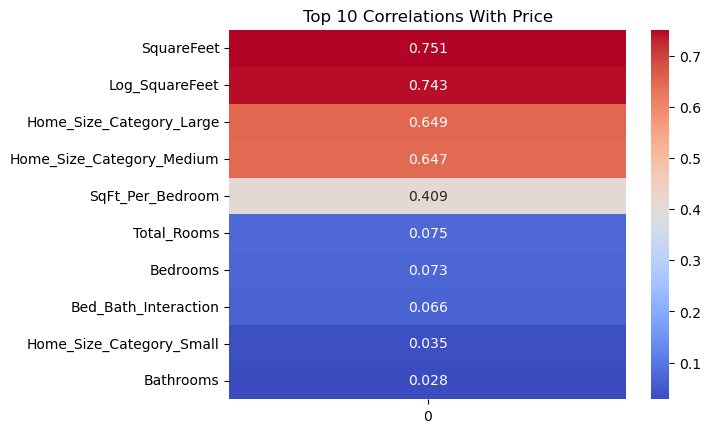

In [32]:
corr = abs(x_df.corrwith(y_df)).sort_values(ascending=False).head(10)
corr_df = pd.DataFrame(corr)
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.3f')
plt.title("Top 10 Correlations With Price")
plt.show()

### **Seperating DataSet into Train, Validation and Test datasets**

In [33]:
x_temp , x_test , y_temp , y_test = train_test_split(x_df,y_df,test_size=0.2,random_state=7)
x_train , x_val , y_train , y_val = train_test_split(x_temp,y_temp,test_size=0.25,random_state=7)

In [34]:
len(x_train),len(x_val),len(x_test)

(30000, 10000, 10000)

### **Creating BaseLine Models**

In [35]:
def mean(inputs,targets):
    preds = np.full_like(targets,np.mean(targets))
    mae = mean_absolute_error(preds,targets)
    print("mean absolute error is:",round(mae,3))
    return None
    

In [36]:
def median(inputs,targets):
    preds = np.full_like(targets,np.median(targets))
    mae = mean_absolute_error(preds,targets)
    print("mean absolute error is:",round(mae,3))
    return None
    

In [37]:
mean(x_train,y_train)

mean absolute error is: 62203.59


In [38]:
median(x_train,y_train)


mean absolute error is: 62203.546


### **Function to Test various Types of Models**

In [39]:
def try_model(model_name,x_train,y_train,x_val,y_val,x_test,y_test,**params):
    model = model_name(**params)
    model.fit(x_train,y_train)
    preds_1 = model.predict(x_train)
    error_1 = mean_absolute_error(preds_1,y_train)
    preds_2 = model.predict(x_val)
    error_2 = mean_absolute_error(preds_2,y_val)
    preds_3 = model.predict(x_test)
    error_3 = mean_absolute_error(preds_3,y_test)
    print("Model =",model_name)
    print("Train MAE is:",round(error_1,3))
    print("Validation MAE is:",round(error_2,3))
    print("Test MAE is:",round(error_3,3))


In [40]:
try_model(model_name=LinearRegression,x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test)

Model = <class 'sklearn.linear_model._base.LinearRegression'>
Train MAE is: 39800.586
Validation MAE is: 39743.193
Test MAE is: 40363.562


In [41]:
try_model(model_name=XGBRegressor,x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test,  n_jobs=-1,random_state=7)


Model = <class 'xgboost.sklearn.XGBRegressor'>
Train MAE is: 35243.622
Validation MAE is: 40778.504
Test MAE is: 41451.811


In [42]:
try_model(model_name=RandomForestRegressor,x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test,  n_jobs=-1,random_state=7)


Model = <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Train MAE is: 15703.254
Validation MAE is: 42374.453
Test MAE is: 43159.96


### **Bayesian Search to get the best Hyperparameters**

In [43]:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': (10, 500),
    'max_depth': (3, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': ['sqrt', 'log2']
}
# Bayesian Optimization
bayes_search = BayesSearchCV(
    rf, param_grid, n_iter=30, cv=3, n_jobs=-1, random_state=42)
# Fit the model
bayes_search.fit(x_train, y_train)
# Best parameters
print("Best Hyperparameters:", bayes_search.best_params_)

Best Hyperparameters: OrderedDict({'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 481})


In [44]:
try_model(model_name=RandomForestRegressor,x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test,  n_jobs=-1,random_state=7,max_depth= 7, max_features ='log2', min_samples_leaf=10, min_samples_split= 7, n_estimators= 481)


Model = <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Train MAE is: 39320.476
Validation MAE is: 39804.84
Test MAE is: 40414.213


In [45]:
mean(x_val,y_val)

mean absolute error is: 61590.644


In [46]:
median(x_test,y_test) 

mean absolute error is: 62690.705


### **Predicting On The Single Input**

### **Taking The Data From The User and Feature Engineering**

In [47]:
def get_valid_int_input(prompt):
    while True:
        try:
            value = int(input(prompt).strip())
            if value > 0:
                return value
            else:
                print("Value must be positive. Try again.")
        except ValueError:
            print("Invalid input! Please enter a numeric value.")

def get_valid_neighbouhood(prompt):
    valid_options = {'Rural', 'Suburb', 'Urban'}
    while True:
        value = input(prompt).strip().capitalize()
        if value in valid_options:
            return value
        print("Invalid input! Please enter 'Rural', 'Suburb', or 'Urban'.")

# User Inputs
square_feet = get_valid_int_input("How many square feet do you want the house to have? ")
bedrooms = get_valid_int_input("How many bedrooms do you want in the house? ")
bathrooms = get_valid_int_input("How many bathrooms do you want the house to have? ")
neighborhood = get_valid_neighbouhood("Which neighborhood do you want the house to be in? (Rural / Suburb / Urban) ")
year_built = get_valid_int_input("What year do you want the house to have been built? ")

# Define bins for home size categories
max_sqft = df['SquareFeet'].max()  
base_bins = [0, 1000, 2000, 3000, 4000]
bins = sorted(set(base_bins + [max_sqft]))  # Ensure unique and sorted bins
labels = ['Small', 'Medium', 'Large', 'XL', 'Mansion'][:len(bins)-1]

# Construct Single Input Dictionary
single_input = {
    'SquareFeet': square_feet,
    'Bedrooms': bedrooms,
    'Bathrooms': bathrooms,
    'Neighborhood': neighborhood,
    'YearBuilt': year_built,
    'Age': 2025 - year_built,
    'SqFt_Per_Bedroom': square_feet / bedrooms if bedrooms > 0 else square_feet,  
    'Bed_Bath_Ratio': bedrooms / (bathrooms if bathrooms > 0 else 1),  
    'Log_SquareFeet': np.log1p(square_feet),
    'Total_Rooms': bedrooms + bathrooms,
    'Bed_Bath_Interaction': bedrooms * bathrooms,
    'Home_Size_Category': pd.cut([square_feet], bins=bins, labels=labels, include_lowest=True)[0] 
}

print(single_input)


{'SquareFeet': 1500, 'Bedrooms': 3, 'Bathrooms': 2, 'Neighborhood': 'Urban', 'YearBuilt': 2000, 'Age': 25, 'SqFt_Per_Bedroom': 500.0, 'Bed_Bath_Ratio': 1.5, 'Log_SquareFeet': 7.313886831633462, 'Total_Rooms': 5, 'Bed_Bath_Interaction': 6, 'Home_Size_Category': 'Medium'}


### **Preprocessing The Data**

In [48]:
single_input_df = pd.DataFrame([single_input])
single_input_df

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Age,SqFt_Per_Bedroom,Bed_Bath_Ratio,Log_SquareFeet,Total_Rooms,Bed_Bath_Interaction,Home_Size_Category
0,1500,3,2,Urban,2000,25,500.0,1.5,7.313887,5,6,Medium


In [49]:
single_input_df.columns


Index(['SquareFeet', 'Bedrooms', 'Bathrooms', 'Neighborhood', 'YearBuilt',
       'Age', 'SqFt_Per_Bedroom', 'Bed_Bath_Ratio', 'Log_SquareFeet',
       'Total_Rooms', 'Bed_Bath_Interaction', 'Home_Size_Category'],
      dtype='object')

In [50]:
single_input_num_cols = ['SquareFeet',
 'Bedrooms',
 'Bathrooms',
 'YearBuilt',
 'Age',
 'SqFt_Per_Bedroom',
 'Bed_Bath_Ratio',
 'Log_SquareFeet',
 'Total_Rooms',
 'Bed_Bath_Interaction']
single_input_cat_cols = ['neighborhood', 'Home_Size_Category']


In [51]:
single_input_df[single_input_num_cols] = scaler.transform(single_input_df[single_input_num_cols])

In [52]:
single_input_df[encoded_cols] = encoder.transform(single_input_df[categorical_cols])

In [53]:
single_input_df =single_input_df[single_input_num_cols+encoded_cols]

### **Developing The Model On the Best Hyperparameters**

In [54]:
model = RandomForestRegressor(n_jobs=-1,random_state=7,max_depth= 7, max_features ='log2', min_samples_leaf=10, min_samples_split= 7, n_estimators= 481)
model.fit(x_train,y_train)
prediction = model.predict(single_input_df)
print("The Approx Price of your House Is:",round(list(prediction)[0],3))

The Approx Price of your House Is: 171941.144


### **Putting It All Together**

In [62]:
def get_valid_int_input(prompt):
    while True:
        try:
            value = int(input(prompt).strip())
            if value > 0:
                return value
            else:
                print("Value must be positive. Try again.")
        except ValueError:
            print("Invalid input! Please enter a numeric value.")

def get_valid_neighbouhood(prompt):
    valid_options = {'Rural', 'Suburb', 'Urban'}
    while True:
        value = input(prompt).strip().capitalize()
        if value in valid_options:
            return value
        print("Invalid input! Please enter 'Rural', 'Suburb', or 'Urban'.")

# User Inputs
square_feet = get_valid_int_input("How many square feet do you want the house to have? ")
bedrooms = get_valid_int_input("How many bedrooms do you want in the house? ")
bathrooms = get_valid_int_input("How many bathrooms do you want the house to have? ")
neighborhood = get_valid_neighbouhood("Which neighborhood do you want the house to be in? (Rural / Suburb / Urban ")
year_built = get_valid_int_input("What year do you want the house to have been built? ")

# Define bins for home size categories
max_sqft = df['SquareFeet'].max()  
base_bins = [0, 1000, 2000, 3000, 4000]
bins = sorted(set(base_bins + [max_sqft]))  # Ensure unique and sorted bins
labels = ['Small', 'Medium', 'Large', 'XL', 'Mansion'][:len(bins)-1]

# Construct Single Input Dictionary
single_input = {
    'SquareFeet': square_feet,
    'Bedrooms': bedrooms,
    'Bathrooms': bathrooms,
    'Neighborhood': neighborhood,
    'YearBuilt': year_built,
    'Age': 2025 - year_built,
    'SqFt_Per_Bedroom': square_feet / bedrooms if bedrooms > 0 else square_feet,  
    'Bed_Bath_Ratio': bedrooms / (bathrooms if bathrooms > 0 else 1),  
    'Log_SquareFeet': np.log1p(square_feet),
    'Total_Rooms': bedrooms + bathrooms,
    'Bed_Bath_Interaction': bedrooms * bathrooms,
    'Home_Size_Category': pd.cut([square_feet], bins=bins, labels=labels, include_lowest=True)[0] 
}
single_input_df = pd.DataFrame([single_input])
single_input_num_cols = ['SquareFeet',
 'Bedrooms',
 'Bathrooms',
 'YearBuilt',
 'Age',
 'SqFt_Per_Bedroom',
 'Bed_Bath_Ratio',
 'Log_SquareFeet',
 'Total_Rooms',
 'Bed_Bath_Interaction']
single_input_cat_cols = ['neighborhood', 'Home_Size_Category']
single_input_df[single_input_num_cols] = scaler.transform(single_input_df[single_input_num_cols])
single_input_df[encoded_cols] = encoder.transform(single_input_df[categorical_cols])
single_input_df =single_input_df[single_input_num_cols+encoded_cols]
model = RandomForestRegressor(n_jobs=-1,random_state=7,max_depth= 7, max_features ='log2', min_samples_leaf=10, min_samples_split= 7, n_estimators= 481)
model.fit(x_train,y_train)
prediction = model.predict(single_input_df)
print(f"The Data You Entered is:\nSquare Feet is: {square_feet}\nBedrooms are: {bedrooms}\nBathrooms are: {bathrooms}\nNeighborhood is: {neighborhood}\nYear Built is: {year_built}\n")
print("The Approx Price of your House Is:",round(list(prediction)[0],3))


The Data You Entered is:
Square Feet is: 2896
Bedrooms are: 2
Bathrooms are: 1
Neighborhood is: Suburb
Year Built is: 1971

The Approx Price of your House Is: 307078.243


### **Saving Machine Learning Model and Preprocessing Objects with Joblib**

In [ ]:
joblib.dump(scaler,"Scaler.joblib")
joblib.dump(encoder,"Encoder.joblib")
joblib.dump(model,"Model.joblib")
joblib.dump(encoded_cols,"Encoded_cols.joblib")